## Pipeline

In [3]:
import praw

from tqdm import tqdm

import numpy as np
import pandas as pd

import requests
import json

from bs4 import BeautifulSoup

from datetime import datetime, timezone, timedelta
import pytz

import seaborn as sns
import matplotlib.pyplot as plt

**Marketstack Data**

In [4]:
def ticker_history(ticker):
    """ returns trading data of a stock over the last 100 trading days. 
    Args:
        ticker (string): ticker symbol representing inputed stock
        
    Returns:
        df_history (DataFrame): pd DF containing end of day data 
    """
    # define api acess key
    params = {'access_key': 'fb8442e7289f98db111f57de2a4c1d75'}
    
    # call to api with inputed parameters
    api_result = requests.get(f'https://api.marketstack.com/v1/tickers/{ticker}/eod', params)
    
    # convert data to json format
    api_response = api_result.json()
    
    # DataFrame composed of only end of day stock data
    df_history = pd.DataFrame(api_response['data']['eod'])
    
    return df_history

In [5]:
df_aapl_history = ticker_history('aapl')
df_aapl_history.head()

KeyError: 'data'

**Create a DataFrame of all companies listed on the NASDAQ** 

to allow us to figure out which of them have been mentioned on /r/WallStreetBets

In [19]:
# https://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download
df_nasdaq = pd.read_csv('nasdaq-11-02-21.csv')
# add row to track exchange listed on
df_nasdaq['Exchange'] = 'NASDAQ'

**Set up connection to Reddit**

In [20]:
# information to establish connection with Reddit
BOT_USERNAME = 'wsb_scraper_bot'
BOT_PASSWORD = 'wsbscraper123'

USER_AGENT = 'stock_scraper'

PERSONAL_USE_SCRIPT = 'ZtchHXULvjzyMQ'
SECRET_TOKEN = 'hG22Q7q79x8Hy6AVWTDthC0f7QrjJg'

In [21]:
# get reddit instance
reddit = praw.Reddit(client_id=PERSONAL_USE_SCRIPT, 
                     client_secret=SECRET_TOKEN,
                     user_agent=USER_AGENT,
                     username=BOT_USERNAME,
                     password=BOT_PASSWORD, 
                     check_for_async=False)

In [22]:
# getting temporary OAuth token
# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(PERSONAL_USE_SCRIPT, SECRET_TOKEN)

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': BOT_USERNAME,
        'password': BOT_PASSWORD}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'stock_scraper/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requesbts
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

**Collect information from Pushshift**

In [23]:
# taken + modified from 
# https://rareloot.medium.com/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563
def get_pushshift_results(after, before, sub, num_results):
    """ queries pushshift for the most commented on posts in the specified subreddit between the given dates
    Args:
        after (int)           : the date that all searches will be after, as a timestamp
        before (int)          : the date that all searches will be before, as a timestamp
        sub (str)             : the subreddit to search
        num_results (int)     : the number of results to return
    Returns:
        pushshift_dict (dict) : a dictionary containing all results from the Pushshift query
    """
    url = 'https://api.pushshift.io/reddit/search/submission/?size='+str(num_results)+'&after='+str(after)+'&before='+str(before)+'&sort=desc&sort_type=num_comments&subreddit='+str(sub)

    #print(url)
    r = requests.get(url)
    
    # avoid JSONDecodeError
    try:
        data = json.loads(r.text)
        pushshift_dict =  data['data']
    except:
        pushshift_dict = dict()
        
    return pushshift_dict

In [24]:
# collect submissions for every 2 days in the last 100
cur_date = datetime.now() - timedelta(days=100)

# subreddit to search
sub='WallStreetBets'

# list to store pushshift links in
pushshift_all_posts = []

# collecting from every 2 days because otherwise cleaning takes too long
time_delta = timedelta(days=2) 

while(cur_date < datetime.now()):
    # first and last dates to search
    search_start_date = cur_date
    search_end_date = search_start_date + time_delta
    
    # convert search dates to timestamps
    before_ts = int((search_end_date - datetime(1970, 1, 1)).total_seconds())
    after_ts = int((search_start_date - datetime(1970, 1, 1)).total_seconds())
    
    # number of results to return per day
    # 30 chosen to keep runtimes relatively low, but ideally would be higher
    num_results = 30
    
    # store results
    pushshift_results = get_pushshift_results(after_ts, before_ts, sub, num_results)
    
    # add results to list
    pushshift_all_posts.extend(pushshift_results)
    
    # increment date to continue looping
    cur_date += time_delta
    

# we can get the url from each item in pushshift_all_posts and create a submission/post object from it
pushshift_post_list = []
for post in pushshift_all_posts:
    # create a temporary post from the posts's url
    post_temp = post['full_link']
    pushshift_post_list.append(post_temp)

KeyboardInterrupt: 

In [ ]:
len(pushshift_post_list)

1170

**Clean information about each post and comment**

We are ignoring all posts that are not flaired as either `DD` or `Discussion` in order to try and filter out spam and non-serious discussion

In [ ]:
from praw.models import MoreComments
# list of flairs we're interested in
flair_list = ['DD', 'Discussion']

# empty DataFrames to record posts and comments
df_posts = pd.DataFrame()
df_comments = pd.DataFrame()

# loop through all collected links
for i in tqdm(range(len(pushshift_post_list)), desc='all posts and comments'):
    # create submission from the current posts's url
    post_url = pushshift_post_list[i]
    # big try/except to try to prevent JSONDecode errors
    try:
        submission = reddit.submission(url=post_url)
        # if the submission has a flair we are interested in, scrape information
        # about the post and its comments
        if submission.link_flair_text in flair_list:
            # dictionary to store this post's information
            post_dict = {}

            # store important information from the post
            post_dict['date'] = datetime.fromtimestamp(submission.created_utc)
            post_dict['subreddit'] = submission.subreddit
            post_dict['title'] = submission.title 
            post_dict['flair'] = submission.link_flair_text
            post_dict['selftext'] = submission.selftext
            post_dict['upvote_ratio'] = submission.upvote_ratio
            post_dict['ups'] = submission.ups
            post_dict['downs'] = submission.downs
            post_dict['score'] = submission.score
            post_dict['id'] = submission.id
            post_dict['url'] = submission.url

             # append post info to df_posts dataframes
            df_posts = df_posts.append(post_dict, ignore_index=True)

            # comments
            # record post id with each comment to be able to track which comments came from which post
            post_id = submission.id
            # limit = 10 replaces 10 instances of 'MoreComments' and will help speed up the run
            # trying to find a balance between number of comments scraped and a realistic runtime
            submission.comments.replace_more(limit=10)

            for comment in submission.comments.list():
                # dictionary to store this comment's information
                comment_dict = {}
                
                # get important information about comment
                comment_dict['post_id'] = post_id 
                comment_dict['comment_id'] = comment.id
                comment_dict['date'] = datetime.fromtimestamp(comment.created_utc)
                comment_dict['body'] = comment.body
                comment_dict['score'] = comment.score
                
                # append comment info to df_comments
                df_comments = df_comments.append(comment_dict, ignore_index=True)
                
    # from https://stackoverflow.com/questions/1483429/how-to-print-an-exception-in-python
    except Exception as e:
        print(e)
        

In [ ]:
# save to csv so we don't have to wait for the above sections of code to run every time
# contains info for the year up to 14 April 2021
df_posts.to_csv('posts_last_100_days.csv')
df_comments.to_csv('comments_last_100_days.csv')

**compute how many times each stock listed on the NASDAQ is mentioned**

In [1]:
df_posts = pd.read_csv('posts_last_100_days.csv')
df_comments = pd.read_csv('comments_last_100_days.csv')

# remove extra column added by read_csv
del df_posts['Unnamed: 0']
del df_comments['Unnamed: 0']

NameError: name 'pd' is not defined

In [99]:
# check data loaded correctly
df_posts[['date', 'flair', 'score', 'selftext']].head()

,date,flair,score,selftext
0,2021-01-06 01:27:52,Discussion,803.0,Honest question. Not even trolling.\n\nBut wha...
1,2021-01-05 22:14:40,Discussion,2068.0,"As we've seen, there's been a lot of fuckery g..."
2,2021-01-04 19:26:32,DD,194.0,Bionano Geonomics (BNGO)\n\n\nLet’s start with...
3,2021-01-05 16:54:59,DD,157.0,**TLDR: Buy TLRY calls and shares. 🚀🚀🚀🚀🚀**\n\n...
4,2021-01-06 02:05:00,DD,434.0,GME GANGGGG!!! Most of you know I've been long...


In [98]:
df_posts.columns

Index(['date', 'downs', 'flair', 'id', 'score', 'selftext', 'subreddit',
       'title', 'ups', 'upvote_ratio', 'url'],
      dtype='object')

In [101]:
# check data loaded correctly
df_comments.iloc[4:9]

,body,comment_id,date,post_id,score
4,"I went from zero to 600k, married with two kid...",gi9wle9,2021-01-06 05:34:48,krd25b,64.0
5,You acclimate to w/e lifestyle you have appare...,gi948zs,2021-01-06 01:31:45,krd25b,206.0
6,Have you ever scored a 93rd minute game winnin...,gi94a52,2021-01-06 01:32:03,krd25b,104.0
7,Ever taken a really great shit?,gi954kp,2021-01-06 01:39:11,krd25b,47.0
8,"I had a friend who was rich, his father owned ...",gi9exm7,2021-01-06 02:59:28,krd25b,48.0


In [26]:
import re
import itertools

def get_mentions(df_posts, df_comments):
    """ 
    counts the number of times each stock listed on the NASDAQ is mentioned in 
    Reddit posts and comments, on each day
    
    Args:
        df_posts (pd.DataFrame)    : the posts to search through
        df_comments (pd.DataFrame) : the comments to search through
    Returns:
        df_count (pd.DataFrame)    : a dataframe with a row for each stock listed on the NASDAQ.
                                     stores the number of times that stock was mentioned in the 
                                     given posts and comments each day
    """
    
    # convert date cols to datetimes
    df_posts['date'] = pd.to_datetime(df_posts['date']).dt.date.astype(str)
    df_comments['date'] = pd.to_datetime(df_comments['date']).dt.date.astype(str)
    
    # all dates that are represented in information
    cur_date = datetime.now() - timedelta(days=100)

    # look at every single day
    time_delta = timedelta(days=1)
    
    date_list = pd.date_range(datetime.today(), periods=100).tolist()
    
    # get values for double indices
    symbol_list = df_nasdaq['Symbol'].tolist()
    date_list = list(set(df_posts['date'].tolist()))

    # remove common english words from symbol list
    common_word_list = ['ON', 'CAN', 'EDIT', 'GO', 'UK', 'HAS', 'LOVE',
                        'OPEN', 'ANY', 'STAY', 'GOOD', 'HUGE', 'NEXT',
                        'REAL', 'VERY', 'LIFE', 'EVER','FREE', 'IQ', 
                        'HEAR', 'PLAY', 'TELL', 'PLUG', 'ELSE', 'RIDE', 
                        'MARK', 'TURN']

    # list of stock symbols without common english words
    symbol_list = [s for s in symbol_list if s not in common_word_list]
    
    # create (symbol, date) tuples in order to create a heirarchical index for our data
    index_list = [symbol_list, date_list]
    symbol_date_tuples = list(itertools.product(symbol_list, date_list))
    
    # create multiindex (heirarchical index)
    index = pd.MultiIndex.from_tuples(symbol_date_tuples, names=['symbol', 'date'])
    
    # set index
    df_count = pd.DataFrame(index=index)

    # initialize counts to 0
    df_count['count'] = 0
    
    # removed tqdm as it caused google colab to crash - estimate ~3 hr runtime ? start @ 10:28
    for tuple_idx in range(len(symbol_date_tuples)):
        symbol = symbol_date_tuples[tuple_idx][0]
        date = symbol_date_tuples[tuple_idx][1]
        # check post self texts
        df_count.loc[(symbol, date), 'count'] += df_posts.loc[df_posts['date'] == date]['selftext'].str.contains(r'\b' + re.escape(symbol)+ r'\b').sum() 

        # check comment bodiesr
        df_count.loc[(symbol, date), 'count'] += df_comments.loc[df_comments['date'] == date]['body'].str.contains(r'\b' + re.escape(symbol)+ r'\b').sum()
    
    return df_count

In [ ]:
df_counts = get_mentions(df_posts, df_comments)
# save symbol counts per date to csv
df_counts.to_csv('symbol_counts.csv')

## Machine learning and Analysis - SNDL

trying to see if we can find meaningful results for a correlation between \$SNDL mentions and it's price movement, as it is the symbol with the highest standard deviation in its mentions

In [4]:
# reload data from csv
df_counts = pd.read_csv('symbol_counts.csv', index_col=[0,1])

In [5]:
df_counts.head()

count
symbol date             
AACG   2021-01-19      0
       2021-01-26      0
       2021-01-07      0
       2021-01-13      0
       2021-01-15      0

In [6]:
# treat 2nd level index (date) as columns to make it easier to get z scores and standard deviations for mentions 
df_count_unstack = df_counts.unstack(level=1)

In [7]:
df_count_unstack.loc[['SNDL','TSLA', 'AAPL', 'AMD', 'AMZN']]

count                                                         \
date   2021-01-04 2021-01-05 2021-01-06 2021-01-07 2021-01-08 2021-01-09   
symbol                                                                     
SNDL            0          0          0          0          0          0   
TSLA            0          1          3          7        117         72   
AAPL            0          0          0          0          5          3   
AMD             0          0          0          0          1          1   
AMZN            0          0          0          0          6          3   

                                                    ...                        \
date   2021-01-10 2021-01-11 2021-01-12 2021-01-13  ... 2021-03-16 2021-03-28   
symbol                                              ...                         
SNDL            0          0          0          0  ...          0          0   
TSLA          126         46         20         16  ...          0          3   
AAPL            2          3          0          2  ...          1          0   
AMD             3          1          2          2  ...          0          0   
AMZN            7          2          0          0  ...          0          0   

                                                                          \
date   2021-03-29 2021-03-30 2021-03-31 2021-04-01 2021-04-02 2021-04-04   
symbol                                                                     
SNDL            0          0          0          0          0          1   
TSLA            4          5          1          6          4          1   
AAPL            1          6          2          3          0          0   
AMD             1          2          0          1         18          1   
AMZN            0          0          1          0          0          0   

                              
date   2021-04-05 2021-04-06  
symbol                        
SNDL            0          0  
TSLA           11          6  
AAPL            1          1  
AMD             1          0  
AMZN            0          0  

[5 rows x 74 columns]

In [8]:
# swap rows and cols for easier computations/std deviation computation
df_count_t = df_count_unstack.T

In [9]:
# figure out which symbols have the most variance in mentions
std_series = df_count_t.std()

# get top 10 symbols with highest standard deviations
high_std_symbol = std_series.sort_values(ascending=False)[:10]

# list of symbols with highest variance
symbol_list = high_std_symbol.index.tolist()

print(symbol_list)

['SNDL', 'APHA', 'TLRY', 'TSLA', 'AMZN', 'AMD', 'MVIS', 'TA', 'AAPL', 'CGC']


## See if we can find a relationship between mentions and price movement for SNDL, the stock with the highest standard deviation in it's mentions

In [10]:
# remove all symbols that aren't the ones with 10 highest std devs
df_counts_sndl = df_count_unstack.loc[['SNDL']]

df_counts_sndl.head(10)

count                                                         \
date   2021-01-04 2021-01-05 2021-01-06 2021-01-07 2021-01-08 2021-01-09   
symbol                                                                     
SNDL            0          0          0          0          0          0   

                                                    ...                        \
date   2021-01-10 2021-01-11 2021-01-12 2021-01-13  ... 2021-03-16 2021-03-28   
symbol                                              ...                         
SNDL            0          0          0          0  ...          0          0   

                                                                          \
date   2021-03-29 2021-03-30 2021-03-31 2021-04-01 2021-04-02 2021-04-04   
symbol                                                                     
SNDL            0          0          0          0          0          1   

                              
date   2021-04-05 2021-04-06  
symbol                        
SNDL            0          0  

[1 rows x 74 columns]

In [13]:
# convert mentions to zscores
# transpose df_counts_final to make zscore operation easieer, will transpose back later
df_counts_sndl_t = df_counts_sndl.T

# find zscore of mentions of each day
from scipy.stats import zscore
df_counts_sndl_t = df_counts_sndl_t.apply(zscore)

# undo transpose
df_counts_sndl = df_counts_sndl_t.T
df_counts_sndl.T.head()

symbol                SNDL
      date                
count 2021-01-04 -0.156097
      2021-01-05 -0.156097
      2021-01-06 -0.156097
      2021-01-07 -0.156097
      2021-01-08 -0.156097

In [16]:
# Actual Price movements -- if the close price rose or fell each day
# get price history
df_sndl_history = ticker_history('sndl')

# make sure that it is sorted by date so that percent change in price is a meaningful measure
df_sndl_history['date'] = pd.to_datetime(df_sndl_history['date']).dt.date
df_sndl_history = df_sndl_history.sort_values(by='date')

# create column for percent change as a percentage
df_sndl_history['close % change'] = df_sndl_history['close'].pct_change()

# create categories from percent change -- rise, fall, no change
df_sndl_history.loc[df_sndl_history['close % change'] > 0, 'rise/fall'] = 'rise'
df_sndl_history.loc[df_sndl_history['close % change'] < 0, 'rise/fall'] = 'fall'
df_sndl_history.loc[df_sndl_history['close % change'] == 0, 'rise/fall'] = 'no change'

df_sndl_history.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,symbol,exchange,date,close % change,rise/fall
99,0.3460,0.3500,0.2915,0.3009,5.776329e+08,0.3500,0.2915,0.3009,0.3460,5.776329e+08,1.0,SNDL,XNAS,2020-11-24,NaN,NaN
98,0.2827,0.2900,0.2668,0.2800,1.776889e+08,0.2900,0.2668,0.2800,0.2827,1.776889e+08,1.0,SNDL,XNAS,2020-11-25,-0.069458,fall
97,0.3000,0.3993,0.2998,0.3720,3.890959e+08,0.3993,0.2998,0.3720,0.3000,3.890959e+08,1.0,SNDL,XNAS,2020-11-27,0.328571,rise
96,0.4935,0.8600,0.4550,0.7294,2.017439e+09,0.8600,0.4550,0.7294,0.4935,2.017439e+09,1.0,SNDL,XNAS,2020-11-30,0.960753,rise
95,0.9118,0.9500,0.5829,0.6525,1.251403e+09,0.9500,0.5829,0.6525,0.9118,1.251403e+09,1.0,SNDL,XNAS,2020-12-01,-0.105429,fall


In [17]:
df_counts_sndl.T

symbol                SNDL
      date                
count 2021-01-04 -0.156097
      2021-01-05 -0.156097
      2021-01-06 -0.156097
      2021-01-07 -0.156097
      2021-01-08 -0.156097
...                    ...
      2021-04-01 -0.156097
      2021-04-02 -0.156097
      2021-04-04 -0.141567
      2021-04-05 -0.156097
      2021-04-06 -0.156097

[74 rows x 1 columns]

In [18]:
# remove heirarchical index
df_sndl_no_multi_index = df_counts_sndl.T.reset_index()
df_sndl = df_sndl_no_multi_index.reset_index()

# remove unneccesary columns
del df_sndl['level_0']
del df_sndl['index']

df_sndl.head()

symbol,date,SNDL
0,2021-01-04,-0.156097
1,2021-01-05,-0.156097
2,2021-01-06,-0.156097
3,2021-01-07,-0.156097
4,2021-01-08,-0.156097


In [19]:
# combine datasets (reddit + marketstack)
# ensure both date columns are datetime.date objects for consistency
df_sndl['date'] = pd.to_datetime(df_sndl['date']).dt.date
df_sndl_history['date'] = pd.to_datetime(df_sndl_history['date']).dt.date


# remove dates that aren't in both dataframes -- account for markets being closed on weekends and other factors
date_list = df_sndl['date'].tolist()

df_sndl_history = df_sndl_history[df_sndl_history['date'].isin(date_list)]

sndl_date_list = df_sndl_history['date'].tolist()
df_sndl = df_sndl[df_sndl['date'].isin(sndl_date_list)]

df_sndl_history = df_sndl_history.sort_values(by='date')
df_sndl = df_sndl.sort_values(by='date')

# add price movements column - we can just assign a copy since we know both dataframes 
# only contain the same dates and are sorted in the same way
df_sndl['price movement'] = df_sndl_history['rise/fall'].values

df_sndl.head()

symbol,date,SNDL,price movement
0,2021-01-04,-0.156097,rise
1,2021-01-05,-0.156097,fall
2,2021-01-06,-0.156097,rise
3,2021-01-07,-0.156097,rise
4,2021-01-08,-0.156097,fall


## Machine Learning

We are using a K-Nearest Neighbors classifier with 10-fold cross validation to try and predict movements, and checking the results after using different numbers of neighbors

C:\Users\aleja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\aleja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\aleja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\aleja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\aleja\anaconda3\lib\site-packag

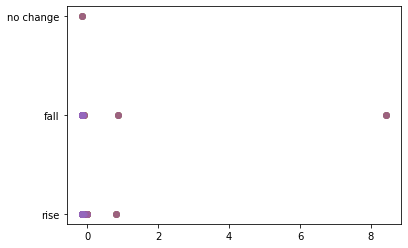

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import normalize

from sklearn.metrics import confusion_matrix

# split columns into x (features) and y (labels)
x_feat_list = ['SNDL']
y_feat = 'price movement'


# get x and y for classifiers
x = df_sndl.loc[:, x_feat_list].values
y_true = df_sndl.loc[:, y_feat].values

# we will be using 10 fold cross validation
n_splits = 10

# dictionary for confusion matrix
conf_matrix_sndl_dict = {}

for k in (1, 5, 11, 15, 27):
    # initialize knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # cross validation
    kfold = StratifiedKFold(n_splits=n_splits)
    
    # y_pred is empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]
        
        # testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]
    
        # train on training data
        knn_classifier.fit(x_train, y_true_train)
        
        # estimat each song's genre
        y_pred[test_idx] = knn_classifier.predict(x_test)
    
    
    # generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    plt.scatter(x, y_true, alpha = 0.5)
    
    # save confusion matrix to conf_matrix_dict
    conf_matrix_sndl_dict[k] = conf_matrix

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

def knn_comparison(data, k):
    # knn neighbours
    n_neighbors = k

    # import some data to play with
    x = data.loc[:, ['SNDL']].values
    y = data.loc[:, 'price movement'].values

    h = .02  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

   
     # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("5-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

In [29]:
def knn_comparison(data, k):
    x = data.loc[:, ['SNDL']].values
    y = data.loc[:, 'price movement'].values
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(x, y)
    # Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    # Adding axes annotations
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Knn with K='+ str(k))
    plt.show()

In [133]:
#!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
def knn_comparison(data, k):
    x = data.loc[:, ['SNDL']].values
    y = data.loc[:, 'price movement'].values.astype(np.integer)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(x, y)
    # Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    # Adding axes annotations
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Knn with K='+ str(k))
    plt.show()

<ipython-input-133-18bba6c7d979>:5: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y = data.loc[:, 'price movement'].values.astype(np.integer)
/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


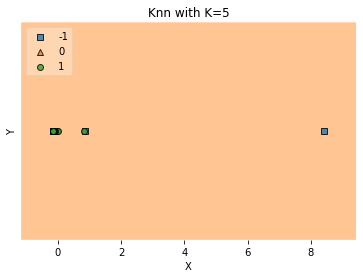

In [134]:
knn_comparison(df_sndl, 5)

In [46]:
def accuracy(conf_matrix):
    """ computes the accuracy of a machine learning classifier based on it's confusion matrix
    Args:
        conf_matrix (np array) : the confusion matrix created by the classifier, stored in 2D np array      
    Returns:
        accuracy (float)       : the classifier's accuracy
    """
    # diagonal entries are correct predictions
    correct = np.diag(conf_matrix).sum()
    
    # total sum is the total number of predictions
    total = conf_matrix.sum()
    
    # accuracy is correct/total
    accuracy = correct / total
    
    return accuracy

In [129]:
# dict to store accuracy based on each confusion matrix
accuracy_sndl_dict = {}

# compute accuracy for all confusion matrices in conf_matrix_dict
for k, conf_matrix in conf_matrix_sndl_dict.items():
    # keys of this dictionary are the same as conf_matrix_dict for clarity
    accuracy_sndl_dict[k] = accuracy(conf_matrix)

In [130]:
# using pprint for better formatting
from pprint import pprint
# print accuracies
pprint(accuracy_sndl_dict)

{1: 0.38461538461538464,
 5: 0.36538461538461536,
 11: 0.38461538461538464,
 15: 0.5576923076923077,
 27: 0.5576923076923077}


## Display Confusion Matrices for SNDL predictions

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

Text(0.5, 0.98, 'K=1 NN Classifier')

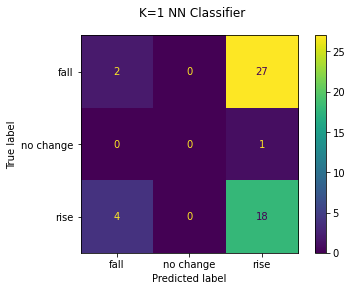

In [50]:
# plot 1-NN confusion matrix
conf_mat_sndl_1 = ConfusionMatrixDisplay(conf_matrix_sndl_dict[1], display_labels=np.unique(y_true))
conf_mat_sndl_1.plot()
plt.suptitle('K=1 NN Classifier')

Text(0.5, 0.98, 'K=5 NN Classifier')

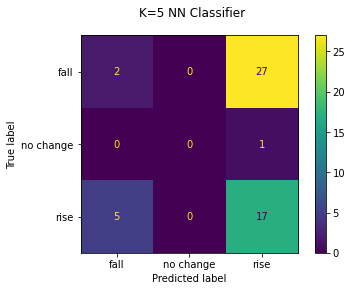

In [51]:
# plot 5-NN confusion matrix
conf_mat_sndl_5 = ConfusionMatrixDisplay(conf_matrix_sndl_dict[5], display_labels=np.unique(y_true))
conf_mat_sndl_5.plot()
plt.suptitle('K=5 NN Classifier')

Text(0.5, 0.98, 'K=11 NN Classifier')

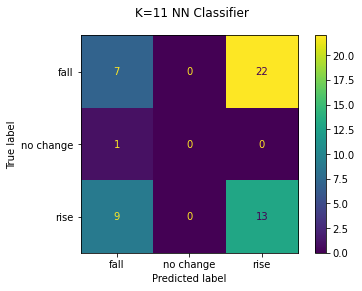

In [52]:
# plot 11-NN confusion matrix
conf_mat_sndl_11 = ConfusionMatrixDisplay(conf_matrix_sndl_dict[11], display_labels=np.unique(y_true))
conf_mat_sndl_11.plot()
plt.suptitle('K=11 NN Classifier')

Text(0.5, 0.98, 'K=15 NN Classifier')

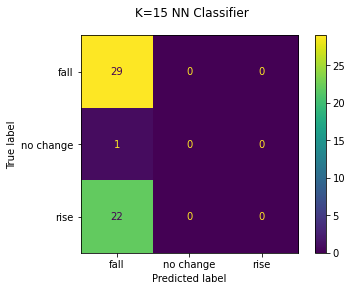

In [55]:
# plot 15-NN confusion matrix
conf_mat_sndl_15 = ConfusionMatrixDisplay(conf_matrix_sndl_dict[15], display_labels=np.unique(y_true))
conf_mat_sndl_15.plot()
plt.suptitle('K=15 NN Classifier')

Text(0.5, 0.98, 'K=27 NN Classifier')

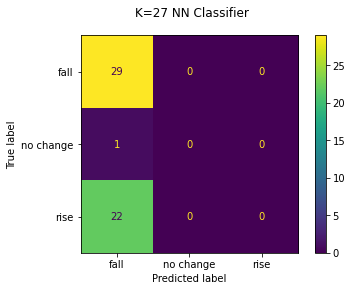

In [56]:
# plot 27-NN confusion matrix
conf_mat_sndl_27 = ConfusionMatrixDisplay(conf_matrix_sndl_dict[27], display_labels=np.unique(y_true))
conf_mat_sndl_27.plot()
plt.suptitle('K=27 NN Classifier')

## Machine learning and Analysis - TSLA

trying to see if we can find meaningful results for a correlation between \$TSLA mentions and it's price movement, as it is amond the symbols with the highest standard deviation in its mentions, while still having a high number of daily mentions

In [8]:
# reload data from csv
df_counts = pd.read_csv('symbol_counts.csv', index_col=[0,1])

In [9]:
df_counts.head()

count
symbol date             
AACG   2021-01-19      0
       2021-01-26      0
       2021-01-07      0
       2021-01-13      0
       2021-01-15      0

In [10]:
# treat 2nd level index (date) as columns to make it easier to get z scores and standard deviations for mentions 
df_count_unstack = df_counts.unstack(level=1)

In [11]:
df_count_unstack.head()

count                                                         \
date   2021-01-04 2021-01-05 2021-01-06 2021-01-07 2021-01-08 2021-01-09   
symbol                                                                     
AACG            0          0          0          0          0          0   
AACQ            0          0          0          0          0          0   
AACQU           0          0          0          0          0          0   
AACQW           0          0          0          0          0          0   
AAL             0          0          0          0          0          0   

                                                    ...                        \
date   2021-01-10 2021-01-11 2021-01-12 2021-01-13  ... 2021-03-16 2021-03-28   
symbol                                              ...                         
AACG            0          0          0          0  ...          0          0   
AACQ            0          0          0          0  ...          0          0   
AACQU           0          0          0          0  ...          0          0   
AACQW           0          0          0          0  ...          0          0   
AAL             0          0          0          0  ...          0          0   

                                                                          \
date   2021-03-29 2021-03-30 2021-03-31 2021-04-01 2021-04-02 2021-04-04   
symbol                                                                     
AACG            0          0          0          0          0          0   
AACQ            0          0          0          0          0          0   
AACQU           0          0          0          0          0          0   
AACQW           0          0          0          0          0          0   
AAL             0          0          0          0          0          0   

                              
date   2021-04-05 2021-04-06  
symbol                        
AACG            0          0  
AACQ            0          0  
AACQU           0          0  
AACQW           0          0  
AAL             0          0  

[5 rows x 74 columns]

In [12]:
# swap rows and cols for easier computations/std deviation computation
df_count_t = df_count_unstack.T

In [13]:
# figure out which symbols have the most variance in mentions
std_series = df_count_t.std()

# get top 10 symbols with highest standard deviations
high_std_symbol = std_series.sort_values(ascending=False)[:10]

# list of symbols with highest variance
symbol_list = high_std_symbol.index.tolist()

print(symbol_list)

['SNDL', 'APHA', 'TLRY', 'TSLA', 'AMZN', 'AMD', 'MVIS', 'TA', 'AAPL', 'CGC']


## See if we can find a relationship between mentions and price movement for SNDL, the stock with the highest standard deviation in it's mentions

In [82]:
# remove all symbols that aren't the ones with 10 highest std devs
df_counts_tsla = df_count_unstack.loc[['TSLA']]

df_counts_tsla.head(10)

count                                                         \
date   2021-01-04 2021-01-05 2021-01-06 2021-01-07 2021-01-08 2021-01-09   
symbol                                                                     
TSLA            0          1          3          7        117         72   

                                                    ...                        \
date   2021-01-10 2021-01-11 2021-01-12 2021-01-13  ... 2021-03-16 2021-03-28   
symbol                                              ...                         
TSLA          126         46         20         16  ...          0          3   

                                                                          \
date   2021-03-29 2021-03-30 2021-03-31 2021-04-01 2021-04-02 2021-04-04   
symbol                                                                     
TSLA            4          5          1          6          4          1   

                              
date   2021-04-05 2021-04-06  
symbol                        
TSLA           11          6  

[1 rows x 74 columns]

In [83]:
# convert mentions to zscores
# transpose df_counts_final to make zscore operation easieer, will transpose back later
df_counts_tsla_t = df_counts_tsla.T

# find zscore of mentions of each day
from scipy.stats import zscore
df_counts_tsla_t = df_counts_tsla_t.apply(zscore)

# undo transpose
df_counts_tsla = df_counts_tsla_t.T
df_counts_tsla.T.head()

symbol                TSLA
      date                
count 2021-01-04 -0.671128
      2021-01-05 -0.626143
      2021-01-06 -0.536173
      2021-01-07 -0.356233
      2021-01-08  4.592122

In [84]:
# Actual Price movements -- if the close price rose or fell each day
# get price history
df_tsla_history = ticker_history('tsla')

# make sure that it is sorted by date so that percent change in price is a meaningful measure
df_tsla_history['date'] = pd.to_datetime(df_tsla_history['date']).dt.date
df_tsla_history = df_tsla_history.sort_values(by='date')

# create column for percent change as a percentage
df_tsla_history['close % change'] = df_tsla_history['close'].pct_change()

# create categories from percent change -- rise, fall, no change
df_tsla_history.loc[df_tsla_history['close % change'] > 0, 'rise/fall'] = 'rise'
df_tsla_history.loc[df_tsla_history['close % change'] < 0, 'rise/fall'] = 'fall'
df_tsla_history.loc[df_tsla_history['close % change'] == 0, 'rise/fall'] = 'no change'

df_tsla_history.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,symbol,exchange,date,close % change,rise/fall
99,492.00,508.6112,487.57,499.27,62475346.0,508.6112,487.57,499.27,492.00,62475346.0,1.0,TSLA,XNAS,2020-11-19,NaN,NaN
98,497.99,502.5000,489.06,489.61,32911922.0,502.5000,489.06,489.61,497.99,32911922.0,1.0,TSLA,XNAS,2020-11-20,-0.019348,fall
97,503.50,526.0000,501.79,521.85,50260304.0,526.0000,501.79,521.85,503.50,50260304.0,1.0,TSLA,XNAS,2020-11-23,0.065848,rise
96,540.40,559.9900,526.20,555.38,52058771.0,559.9900,526.20,555.38,540.40,52058771.0,1.0,TSLA,XNAS,2020-11-24,0.064252,rise
95,550.06,574.0000,545.37,574.00,48930162.0,574.0000,545.37,574.00,550.06,48930162.0,1.0,TSLA,XNAS,2020-11-25,0.033527,rise


In [85]:
df_counts_tsla.T

symbol                TSLA
      date                
count 2021-01-04 -0.671128
      2021-01-05 -0.626143
      2021-01-06 -0.536173
      2021-01-07 -0.356233
      2021-01-08  4.592122
...                    ...
      2021-04-01 -0.401218
      2021-04-02 -0.491188
      2021-04-04 -0.626143
      2021-04-05 -0.176293
      2021-04-06 -0.401218

[74 rows x 1 columns]

In [86]:
# remove heirarchical index
df_tsla_no_multi_index = df_counts_tsla.T.reset_index()
df_tsla = df_tsla_no_multi_index.reset_index()

# remove unneccesary columns
del df_tsla['level_0']
del df_tsla['index']

df_tsla.head()

symbol,date,TSLA
0,2021-01-04,-0.671128
1,2021-01-05,-0.626143
2,2021-01-06,-0.536173
3,2021-01-07,-0.356233
4,2021-01-08,4.592122


In [87]:
# combine datasets (reddit + marketstack)
# ensure both date columns are datetime.date objects for consistency
df_tsla['date'] = pd.to_datetime(df_tsla['date']).dt.date
df_tsla_history['date'] = pd.to_datetime(df_tsla_history['date']).dt.date

# remove dates that aren't in both dataframes -- account for markets being closed on weekends and other factors
date_list = df_tsla['date'].tolist()

df_tsla_history = df_tsla_history[df_tsla_history['date'].isin(date_list)]

tsla_date_list = df_tsla_history['date'].tolist()
df_tsla = df_tsla[df_tsla['date'].isin(tsla_date_list)]

df_tsla_history = df_tsla_history.sort_values(by='date')
df_tsla = df_tsla.sort_values(by='date')

# add price movements column - we can just assign a copy since we know both dataframes 
# only contain the same dates and are sorted in the same way
df_tsla['price movement'] = df_tsla_history['rise/fall'].values

df_tsla.head()

symbol,date,TSLA,price movement
0,2021-01-04,-0.671128,rise
1,2021-01-05,-0.626143,rise
2,2021-01-06,-0.536173,rise
3,2021-01-07,-0.356233,rise
4,2021-01-08,4.592122,rise


## Machine Learning

We are using a K-Nearest Neighbors classifier with 10-fold cross validation to try and predict movements, and checking the results after using different numbers of neighbors

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import normalize

from sklearn.metrics import confusion_matrix

# split columns into x (features) and y (labels)
x_feat_list = ['TSLA']
y_feat = 'price movement'


# get x and y for classifiers
x = df_tsla.loc[:, x_feat_list].values
y_true = df_tsla.loc[:, y_feat].values

# we will be using 10 fold cross validation
n_splits = 10

# dictionary for confusion matrix
conf_matrix_tsla_dict = {}

for k in (1, 5, 11, 15, 27):
    # initialize knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # cross validation
    kfold = StratifiedKFold(n_splits=n_splits)
    
    # y_pred is empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]
        
        # testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]
    
        # train on training data
        knn_classifier.fit(x_train, y_true_train)
        
        
        y_pred[test_idx] = knn_classifier.predict(x_test)
    
    
    # generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    # save confusion matrix to conf_matrix_dict
    conf_matrix_tsla_dict[k] = conf_matrix

In [89]:
# dict to store accuracy based on each confusion matrix
accuracy_tsla_dict = {}

# compute accuracy for all confusion matrices in conf_matrix_dict
for k, conf_matrix in conf_matrix_tsla_dict.items():
    # keys of this dictionary are the same as conf_matrix_dict for clarity
    accuracy_tsla_dict[k] = accuracy(conf_matrix)

In [90]:
# using pprint for better formatting
from pprint import pprint
# print accuracies
pprint(accuracy_tsla_dict)

{1: 0.40384615384615385,
 5: 0.5961538461538461,
 11: 0.5,
 15: 0.5576923076923077,
 27: 0.5384615384615384}


## Display Confusion Matrices for SNDL predictions

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

Text(0.5, 0.98, 'K=1 NN Classifier')

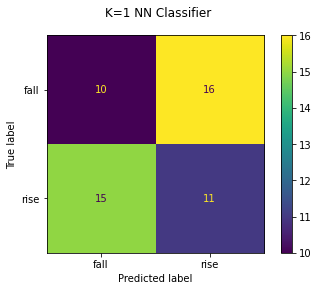

In [92]:
# plot 1-NN confusion matrix
conf_mat_tsla_1 = ConfusionMatrixDisplay(conf_matrix_tsla_dict[1], display_labels=np.unique(y_true))
conf_mat_tsla_1.plot()
plt.suptitle('K=1 NN Classifier')

Text(0.5, 0.98, 'K=5 NN Classifier')

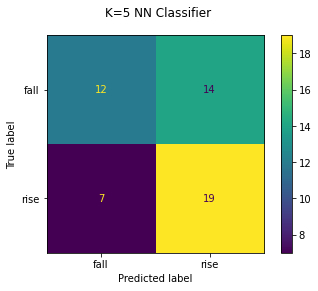

In [93]:
# plot 5-NN confusion matrix
conf_mat_tsla_5 = ConfusionMatrixDisplay(conf_matrix_tsla_dict[5], display_labels=np.unique(y_true))
conf_mat_tsla_5.plot()
plt.suptitle('K=5 NN Classifier')

Text(0.5, 0.98, 'K=11 NN Classifier')

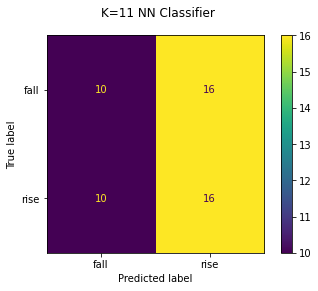

In [94]:
# plot 11-NN confusion matrix
conf_mat_tsla_11 = ConfusionMatrixDisplay(conf_matrix_tsla_dict[11], display_labels=np.unique(y_true))
conf_mat_tsla_11.plot()
plt.suptitle('K=11 NN Classifier')

Text(0.5, 0.98, 'K=15 NN Classifier')

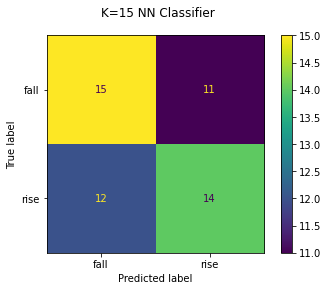

In [95]:
# plot 15-NN confusion matrix
conf_mat_tsla_15 = ConfusionMatrixDisplay(conf_matrix_tsla_dict[15], display_labels=np.unique(y_true))
conf_mat_tsla_15.plot()
plt.suptitle('K=15 NN Classifier')

Text(0.5, 0.98, 'K=27 NN Classifier')

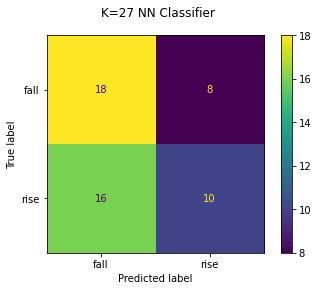

In [96]:
# plot 27-NN confusion matrix
conf_mat_tsla_27 = ConfusionMatrixDisplay(conf_matrix_tsla_dict[27], display_labels=np.unique(y_true))
conf_mat_tsla_27.plot()
plt.suptitle('K=27 NN Classifier')

## Visualizations

**Total number of mentions per symbol (top 25)**

In [1]:
from matplotlib import pyplot

stocks = df_counts['Symbol'][:25]
mentions = df_counts['count'][:25]

fig, ax = pyplot.subplots(figsize=(15, 7))

sns.barplot(ax=ax, x=stocks, y=mentions)

NameError: name 'df_counts' is not defined

**How many times per day was each of the top 5 stocks mentioned?**

In [34]:
# get the price history of each of the top 5 stocks
df_amd_history = ticker_history('amd')
df_apha_history = ticker_history('apha')
df_sndl_history = ticker_history('sndl')
df_tlry_history = ticker_history('tlry')
df_tsla_history = ticker_history('tsla')

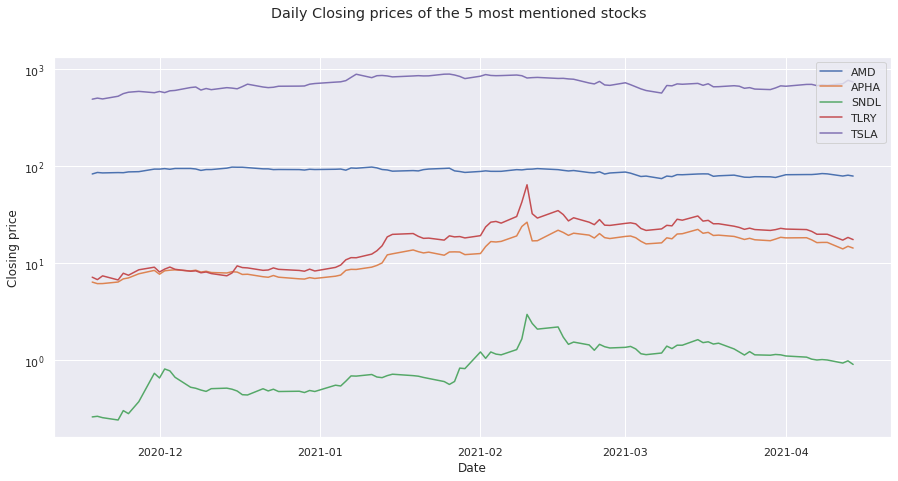

In [35]:
sns.set()

# plot date on the x axis and counts on the y axis
date = np.array(pd.to_datetime(df_amd_history['date']).apply(lambda x: x.date()))
# AMD mentions
amd = np.array(df_amd_history['close'])
# APHA mentions
apha = np.array(df_apha_history['close'])
# SNDL mentions
sndl = np.array(df_sndl_history['close'])
# TLRY mentions
tlry = np.array(df_tlry_history['close'])
# TSLA mentions
tsla = np.array(df_tsla_history['close'])

# get figure
fig = plt.figure()

# alpha value to use
alpha = 1

# plot each symbol's mentions vs the date
plt.plot(date, amd, label='AMD')
plt.plot(date, apha, label='APHA')
plt.plot(date, sndl, label='SNDL')
plt.plot(date, tlry, label='TLRY')
plt.plot(date, tsla, label='TSLA')

# labels
plt.xlabel('Date')
plt.ylabel('Closing price')

# log scale for y
plt.gca().set_yscale('log')

# legend
plt.legend()

# plot title
plt.suptitle('Daily Closing prices of the 5 most mentioned stocks')
# plot size
plt.gcf().set_size_inches(15, 7)

## Analysis
**Project Goal:** The goal of this project is to predict stock price movements based on discussion in /r/WallStreetBets.
- This is observeable: There is both lots of information that can be collected about stock prices, and lots of content posted on /r/WallStreetBets every day. However, as we can see from the bar chart showing the number of mentions of the top 25 symbols, there is significantly less discussion about less popular stocks, so we may need to think carefully about which stocks' movements we try to predict. We will also have to determine the window of time in which this prediction is the most accurate.
- This is sound and simple: it seems intuitive that there would be a relationship between the amount of discussion around a stock and changes in it's price, especially large increases.

Our expectiation is that increased discussion of a stock (which means increased mentions of it) will generally be correlated with changes in it's price. 

Scraping posts and comments from /r/WallStreetBets will allow us to know which stocks are consistently among the most discussed, which will allow us to know which stocks to focus on predicting movements for. In our case, `df_counts` is the sorted DataFrame containing the number of times each stock symbol was mentioned in /r/WallStreetBets, allowing us to find the 10 most discussed stocks:

In [30]:
df_counts[:10]

count
symbol date             
AACG   2021-01-19      0
       2021-01-26      0
       2021-01-07      0
       2021-01-13      0
       2021-01-15      0
       2021-01-16      0
       2021-03-28      0
       2021-03-03      0
       2021-02-25      0
       2021-01-23      0

Having daily open and close data for a variety of stocks will allow us to know if and how much a stock's price changes day-to-day. An example for a few days of TSLA data is below:

In [31]:
df_tsla_history['close price % change'] = df_tsla_history['close'].pct_change()
df_tsla_history.head()

NameError: ignored

We can use a combination of these approaches to find the number of mentions of each stock that we are looking for for every day that we collect data for and find the day-to-day variation in number of mentions. This, combined with other features such as the number of upvotes that comments and posts recieve, number of comments on a post, will allow us to classify whether or not there will be an increase in price within a pre-defined window of time.